In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from langdetect import detect
import re
from tqdm import tqdm
tqdm.pandas()

C:\Users\charl\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# data taken directly from kaggle so I can proceed with analysis. Will come back and parse manually.
# https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv/data?select=clean_pmc.csv 
data = pd.read_csv("Data/clean_pmc.csv", nrows=1000)

In [3]:
data.shape

(1000, 9)

In [4]:
data.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,14572a7a9b3e92b960d92d9755979eb94c448bb5,Immune Parameters of Dry Cows Fed Mannan Oligo...,"S T Franklin, M C Newman, K E Newman, K I Meek","S T Franklin (University of Kentucky, 40546-02...",Abstract\n\nThe objective of this study was to...,INTRODUCTION\n\nThe periparturient period is a...,Immune response of pregnant heifers and cows t...,"[{'first': 'S', 'middle': ['T'], 'last': 'Fran...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Immune ..."
1,bb790e8366da63c4f5e2d64fa7bbd5673b93063c,Discontinuous Transcription or RNA Processing ...,"Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...","Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...",NaN,Discontinuous\n\nTranscription or RNA Processi...,Poly (riboadenylic acid) preferentially inhibi...,"[{'first': 'Beate', 'middle': [], 'last': 'Sch...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Poly (r..."
2,24f204ce5a1a4d752dc9ea7525082d225caed8b3,NaN,NaN,NaN,NaN,Letter to the Editor\n\nThe non-contact handhe...,Novel coronavirus is putting the whole world o...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Novel c..."
3,f5bc62a289ef384131f592ec3a8852545304513a,Pediatric Natural Deaths 30,"Elizabeth C Burton, Nicole A Singer",Elizabeth C Burton (Johns Hopkins University S...,NaN,"Introduction\n\nWorldwide, the leading causes ...",In athletes who experienced sudden death or in...,"[{'first': 'Elizabeth', 'middle': ['C'], 'last...","{'BIBREF0': {'ref_id': 'b0', 'title': 'In athl..."
4,ab78a42c688ac199a2d5669e42ee4c39ff0df2b8,A real-time convective PCR machine in a capill...,"Yi-Fan Hsieh, Da-Sheng Lee, Ping-Hei Chen, Sha...","Yi-Fan Hsieh (National Taiwan University, 106,...","Abstract\n\nThis research reports the design, ...",Introduction\n\nMullis et al. developed the po...,"The Polymerase Chain Reaction, K B Mullis, F F...","[{'first': 'Yi-Fan', 'middle': [], 'last': 'Hs...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The Pol..."


In [5]:
# only keep rows that contain an alpha character (a letter) as
# detect() throws an error if this isn't the case
data_cleaned = data[data['text'].apply(lambda x: bool(re.match('.*[a-zA-Z]+', x)))]

In [6]:
# create pd.Series that predicts the language of the text. Because this takes ~30 mins to run,
# export the result to CSV which can then be imported. The two lines of code that create the CSV
# have been commented out.

lang = data_cleaned['text'].progress_apply(detect)
# lang.to_csv("Data/predicted_lang.csv")
# lang = pd.read_csv("Data/predicted_lang.csv", index_col=0).squeeze()

100%|██████████| 685/685 [01:24<00:00,  8.06it/s]


In [7]:
# filter only english text
data_eng = data_cleaned[lang == 'en']
print('Rows before removing non-english:', data_cleaned.shape[0])
print('Rows after removing non-english:', data_eng.shape[0])

Rows before removing non-english: 685
Rows after removing non-english: 665


### Latent Dirichlet Allocation (LDA)

In [8]:
stopwords=set(nltk.corpus.stopwords.words('english'))

In [9]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words=stopwords)
data_vectorized = vectorizer.fit_transform(data_eng['text'])

<AxesSubplot:ylabel='word'>

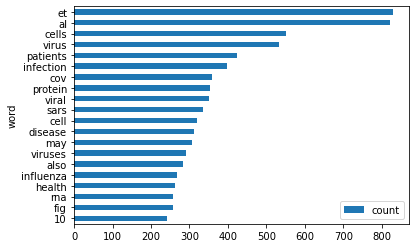

In [10]:
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [13]:
lda = LatentDirichletAllocation(n_components=5)
lda.fit_transform(data_vectorized)

array([[0.01685458, 0.01685458, 0.01685458, 0.93258168, 0.01685458],
       [0.01302385, 0.01302384, 0.01302385, 0.94790462, 0.01302384],
       [0.02366972, 0.02366971, 0.02366971, 0.90532115, 0.02366971],
       ...,
       [0.00969589, 0.00969589, 0.00969589, 0.96121645, 0.00969589],
       [0.01067501, 0.010675  , 0.010675  , 0.95729999, 0.010675  ],
       [0.01855413, 0.01855413, 0.01855413, 0.92578349, 0.01855413]])

In [14]:
# taken from https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles#Latend-Dirichlet-Allocation
for topic_idx, topic in enumerate(lda.components_):
    feature_names = vectorizer.get_feature_names()
    message = f'\nTopic {topic_idx + 1}: '
    message += " ".join([feature_names[i] for i in topic.argsort()[:-5 - 1:-1]])
    print(message)


Topic 1: ectrim13 caws amifn fnov sqe

Topic 2: avfc vsels bw001 hspcft drak2

Topic 3: thnt atanyl cqds ncovid mrfp1

Topic 4: et al cells virus patients

Topic 5: mvtt mimicyp n192 r190 nbreg


How long should people infected with the virus isolate for? Possible steps to answer this are:
- Find all terms that describe isolation (incubation, quarantine, isolation, infectious, transmissable, spreading, transferable, contagious)
- Look for all numbers used near these words that describe the recommend isolation period. Potentially ensure the word "days" is present near the number.
- Put all numbers into a list and average them to determine the recommended isolation period.
- Spot check a few examples to check it's working as expected.

In [69]:
days=[]
for index, row in data_eng.iterrows():
    days_in_text=[]
    for string in row['text'].split():
        if string.isdigit():
            try:
                days_in_text.append(int(string))
            except:
                continue
    days.extend(days_in_text)


In [73]:
np.asarray(days).mean()

390556.12494746654